In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
###################################
# TensorFlow wizardry
import tensorflow as tf
config = tf.ConfigProto()
 
# Don’t pre-allocate memory; allocate as-needed
config.gpu_options.allow_growth = True
 
# Only allow a total of half the GPU memory to be allocated
config.gpu_options.per_process_gpu_memory_fraction = 0.05
#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
 
# Create a session with the above options specified.
from keras import optimizers, regularizers
from keras.layers.normalization import BatchNormalization
from keras.utils import to_categorical
from keras.wrappers.scikit_learn import KerasClassifier
from keras import optimizers
from keras.constraints import maxnorm
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping

from keras.models import Sequential, Model, load_model
from keras.layers import Activation, Dense, Dropout, Input
from keras import backend as k

k.tensorflow_backend.set_session(tf.Session(config=config))
#k.tensorflow_backend.set_session(tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
###################################

Using TensorFlow backend.


In [3]:
#----------------------------------Import modules------------------------------
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score, roc_curve, auc
from sklearn import preprocessing
sns.set_style("whitegrid")
np.random.seed(23)
import time
from sklearn.model_selection import GridSearchCV
import sklearn.metrics as sm
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_predict


In [4]:
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [5]:
pathds = '/home/user/01Code/00Datasets_final/'

In [6]:
#df_chunk = pd.read_csv(pathds+'SubsetAllSamples/ThirdCloneID10bal_minmax.csv', chunksize=1000)
#df = df_chunk.get_chunk(300000)
df = pd.read_csv(pathds+'SubsetAllSamples/ThirdCloneID100bal_stdscal.csv')

In [7]:
df.shape

(547846, 198)

#### 4.2 Explaining the data

In [8]:
#if you don't have an intuitive sense of how imbalanced these two classes are, let's go visual
count_classes = pd.value_counts(df['class'], sort = True)
print('Class 0:', count_classes[0])
print('Class 1:', count_classes[1])
print('Proportion:', round(count_classes[0] / count_classes[1], 3), ': 1')

Class 0: 273923
Class 1: 273923
Proportion: 1.0 : 1


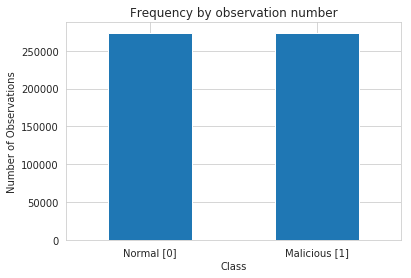

In [9]:
count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), ['Normal [0]','Malicious [1]'])
plt.title("Frequency by observation number")
plt.xlabel("Class")
plt.ylabel("Number of Observations");

In [10]:
#set random seed and percentage of test data
RANDOM_SEED = 23 #used to help randomly select the data points
TEST_PCT = 0.20 # 20% of the data

In [11]:
train, test_df = train_test_split(df, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ df -> original dataset 
+ train -> subset of 80% from original dataset 
+ test_df -> subset of 20% from original dataset 

In [12]:
train_df, dev_df = train_test_split(train, test_size=TEST_PCT, random_state=RANDOM_SEED)

+ train -> subset of 80% from original dataset 
+ train_df -> subset of 80% from train
+ dev_df -> subset of 20% from train

In [13]:
# Check distribution of mal samples in train and test set
print(train_df.iloc[:, 197].sum()/train_df.shape[0]) 
print(dev_df.iloc[:, 197].sum()/dev_df.shape[0]) 
print(test_df.iloc[:, 197].sum()/test_df.shape[0])

0.4996463407677828
0.500867025645706
0.5004380761157251


In [14]:
train_x = train_df.iloc[:, :197] 
dev_x = dev_df.iloc[:, :197] 
test_x = test_df.iloc[:, :197] 

+ train_x -> features of train_df **Training subset for AE**
+ dev_x -> features of dev_df **Validation subset for AE**
+ test_x -> features of test_df **Testing subset for ANN**

In [15]:
# Define the final train and test sets
train_y = train_df.iloc[:, 197]
dev_y = dev_df.iloc[:, 197]
test_y = test_df.iloc[:, 197]

+ train_y -> **Labels for supervised training of ANN**
+ dev_y -> labels of dev_df  *not used for AE neither ANN*
+ test_y -> labels of test_df  **Ground Truth for predictions of supervised ANN**

In [16]:
train_x =np.array(train_x)
dev_x =np.array(dev_x)
test_x = np.array(test_x)

train_y = np.array(train_y)
dev_y = np.array(dev_y)
test_y = np.array(test_y)

print(train_x.shape[1])

197


### Autoencoder Function

encoding_dim - 2

Epoch 94/300 78596/78596 [==============================] - 10s 125us/step 
- loss: 3.8990e-05 - acc: 0.0237 - 
        val_loss: 3.9704e-05 - val_acc: 0.0236

In [17]:
def ae(factor_enc_dim, enc_activation, dec_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer #RELU
    encoded = Dense(encoding_dim, activation=enc_activation, name='encoded_bottle_neck')(input_data)
    ### Define decoding layer #SIMOID
    decoded = Dense(train_x.shape[1], activation=dec_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [18]:
def sae(factor_enc_dim, output_activation,
        optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activation='relu', name='input_layer')(input_data)
    encoded = Dense(int(encoding_dim/2), activation='relu')(encoded) ##Stacked AE
    encoded_bottle_neck = Dense(int(encoding_dim/4), activation='relu', name='enc_bottle_neck')(encoded) ##Stacked AE
    
    ### Define decoding layer
    decoded = Dense(int(encoding_dim/2), activation='relu')(encoded_bottle_neck) ##Stacked AE
    decoded = Dense(encoding_dim, activation='relu')(decoded) ##Stacked AE
    decoded = Dense(train_x.shape[1], activation=output_activation)(decoded)
    
    ### Create the autoencoder model
    sae = Model(input_data, decoded)
    sae.compile(optimizer=optimizer,
                loss=loss,
                metrics=['accuracy'])
    
    print(sae.summary())

    encoder = Model(input_data, encoded_bottle_neck)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return sae,encoded_train_x,encoded_test_x

In [19]:
def spae(factor_enc_dim, output_activation, 
                optimizer, loss):

    encoding_dim = int(int(train_x.shape[1])/factor_enc_dim)
    ### Define input layer
    input_data = Input(shape=(train_x.shape[1],))
    ### Define encoding layer
    encoded = Dense(encoding_dim, activity_regularizer=regularizers.l1(1e-4), activation='relu', name='encoded_bottle_neck')(input_data)
    ### Define decoding layer
    decoded = Dense(train_x.shape[1], activation=output_activation)(encoded)
    ### Create the autoencoder model
    autoencoder = Model(input_data, decoded)
    autoencoder.compile(optimizer=optimizer,
                        loss=loss,
                        metrics=['accuracy'])
    
    print(autoencoder.summary())
    
    encoder = Model(input_data, encoded)
    encoded_train_x = encoder.predict(train_x)
    encoded_test_x = encoder.predict(test_x)
    
    return autoencoder,encoded_train_x,encoded_test_x

In [20]:
def fit_ae(checkpoint_file, autoencoder,
           epochs, batch_size, shuffle):
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    hist_auto = autoencoder.fit(train_x, train_x,
                    epochs=epochs,
                    batch_size=batch_size,
                    shuffle=shuffle,
                    verbose=1,
                    callbacks=[early_stopping, cp, tb],
                    validation_data=(dev_x, dev_x))

    elapsed_time = (time.time() - start_time)
    print("--- AE spent %s seconds ---" % elapsed_time)
    
    return hist_auto

In [21]:
def plot_hist_auto(hist_auto, fig_file):
    best_loss_value = hist_auto.history['loss'][-1]
    print('Best loss value:', best_loss_value)

    # Summarize history for loss
    plt.figure()
    plt.plot(hist_auto.history['loss'])
    plt.plot(hist_auto.history['val_loss'])
    plt.title('Autoencoder model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')
    plt.savefig(fig_file)
    plt.show()
    
    return best_loss_value

In [22]:
def ann_2h(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model 197
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(145, activation="relu", kernel_initializer=init_mode)) #rezvy

    model.add(Dense(95, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [23]:
def ann_2h_(neurons,encoded_train_x,init_mode,activation_input,
               dropout_rate,activation_output,
               loss,lr):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(145, activation="relu")) #rezvy

    model.add(Dense(95, activation="relu")) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example

    optimizer = optimizers.Adam(lr=lr)
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [24]:
def ann_2h__(neurons,encoded_train_x,activation_input,
             activation_output,loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
#                     kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(145, activation="relu")) #rezvy

    model.add(Dense(95, activation="relu")) #rezvy
#     model.add(BatchNormalization()) #commented for ex
#     model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example

#     optimizer = optimizers.Adam(lr=lr)
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [25]:
def ann_1h_36n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(145, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [26]:
def ann_1h_24n(neurons,encoded_train_x,init_mode,activation_input,
               weight_constraint,dropout_rate,activation_output,
               loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
                    kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
                    kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(95, activation="relu", kernel_initializer=init_mode)) #rezvy
    model.add(BatchNormalization()) #commented for ex
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [27]:
def ann_1h_24n_(neurons,encoded_train_x,activation_input,
               activation_output,loss,optimizer):

    # create model
    model = Sequential()

    model.add(Dense(neurons, input_dim=encoded_train_x.shape[1],
#                     kernel_initializer=init_mode,
                    #kernel_regularizer=regularizers.l2(0.02), #from example
                    activation=activation_input,
#                     kernel_constraint=maxnorm(weight_constraint)
                    )
              )

#     #Hidden Layer
    model.add(Dense(95, activation="relu")) #rezvy
    
#     model.add(BatchNormalization()) #commented for ex
#     model.add(Dropout(dropout_rate))
    
    model.add(Dense(1, activation=activation_output)) #example
    
    # Compile model
    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=['accuracy'])
    
    print(model.summary())
    
    return model

In [28]:
def ann_fit(checkpoint_file,ann,enc_train_x,train_y,epochs,shuffle,batch_size):
    early_stopping = EarlyStopping(monitor='val_loss', patience=5)

    cp = ModelCheckpoint(filepath=checkpoint_file,
                                   save_best_only=True,
                                   verbose=0)

    tb = TensorBoard(log_dir='./logs',
                    histogram_freq=0,
                    write_graph=True,
                    write_images=True)

    start_time = time.time()
    print(time.ctime(start_time))

    history = ann.fit(enc_train_x,
                      train_y,
                      validation_split=0.2,
                      callbacks=[early_stopping],
                      epochs=epochs,
                      shuffle=shuffle,
                      batch_size=batch_size,
                      verbose=1)

    elapsed_time = (time.time() - start_time)
    print("--- ANN spent %s seconds ---" % elapsed_time)

    return history

In [29]:
def ann_predict(ann,enc_test_x):
    pred_ann_prob = ann.predict(enc_test_x)
    pred_ann_prob.shape
    pred_ann_prob = pred_ann_prob[:,0]
    pred_ann_01 = np.where(pred_ann_prob > 0.5, 1, 0)
    
    #Print accuracy
    acc_ann = accuracy_score(test_y, pred_ann_01)
    print('Overall accuracy of Neural Network model:', acc_ann)

    classiBM = "NN"
    preBM = (sm.precision_score(test_y, pred_ann_01)*100) 
    recallBM = (sm.recall_score(test_y, pred_ann_01)*100) 
    f1scoreBM = (sm.f1_score(test_y, pred_ann_01)*100)
    print(sm.classification_report(test_y, pred_ann_01,digits=4))
    
    return pred_ann_prob, pred_ann_01

In [30]:
def plot_roc_cm(pred_ann_prob, pred_ann_01, roc_file, cm_file):
    false_positive_rate, recall, thresholds = roc_curve(test_y, pred_ann_prob)
    roc_auc = auc(false_positive_rate, recall)
    plt.figure()
    plt.title('Receiver Operating Characteristic (ROC)')
    plt.plot(false_positive_rate, recall, 'b', label = 'AUC = %0.3f' %roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0,1], [0,1], 'r--')
    plt.xlim([0.0,1.0])
    plt.ylim([0.0,1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out (1-Specificity)')
    plt.savefig(roc_file)
    plt.show()
    
    cm = confusion_matrix(test_y, pred_ann_01)
    labels = ['Normal', 'Malicious']
    plt.figure(figsize=(8,6))
    sns.heatmap(cm,xticklabels=labels, yticklabels=labels, annot=True, fmt='d', cmap="RdYlGn", vmin = 0.2);
    plt.title('Confusion Matrix')
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.savefig(cm_file)
    plt.show()
    

loss: 2.7516e-05 - acc: 0.0407 

val_loss: 2.7072e-05 - val_acc: 0.0399

In [31]:
ae_sigmoid_adam_logcosh,enc_train_x_asal,enc_test_x_asal = ae(factor_enc_dim = 1.5,
                                                              enc_activation = 'relu',
                                                              dec_activation = 'sigmoid',
                                                              optimizer='Adam',
                                                              loss='logcosh')

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 197)               0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 131)               25938     
_________________________________________________________________
dense_1 (Dense)              (None, 197)               26004     
Total params: 51,942
Trainable params: 51,942
Non-trainable params: 0
_________________________________________________________________
None


In [32]:
#ae_sigmoid_adam_logcosh = load_model('ae_sigmoid_adam_logcosh_redds10bal.h5')

In [33]:
hist_ae_sigmoid_adam_logcosh = fit_ae(checkpoint_file = "ae_sigmoid_adam_logcosh_redds100bal.h5",
                                        autoencoder = ae_sigmoid_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 197, 
                                        shuffle = False)

Mon Jun 10 16:29:28 2019
Instructions for updating:
Use tf.cast instead.
Train on 350620 samples, validate on 87656 samples
Epoch 1/200
350620/350620 [==============================] - 5s 13us/step - loss: 0.0232 - acc: 0.2369 - val_loss: 0.0200 - val_acc: 0.3055
Epoch 2/200
350620/350620 [==============================] - 4s 12us/step - loss: 0.0189 - acc: 0.3261 - val_loss: 0.0183 - val_acc: 0.3532
Epoch 3/200
350620/350620 [==============================] - 4s 12us/step - loss: 0.0181 - acc: 0.3376 - val_loss: 0.0181 - val_acc: 0.3250
Epoch 4/200
350620/350620 [==============================] - 4s 12us/step - loss: 0.0180 - acc: 0.3172 - val_loss: 0.0180 - val_acc: 0.2702
Epoch 5/200
350620/350620 [==============================] - 4s 12us/step - loss: 0.0180 - acc: 0.2616 - val_loss: 0.0180 - val_acc: 0.2095
Epoch 6/200
350620/350620 [==============================] - 4s 12us/step - loss: 0.0179 - acc: 0.2482 - val_loss: 0.0180 - val_acc: 0.2611
Epoch 7/200
350620/350620 [=========

Best loss value: 0.017835762382374845


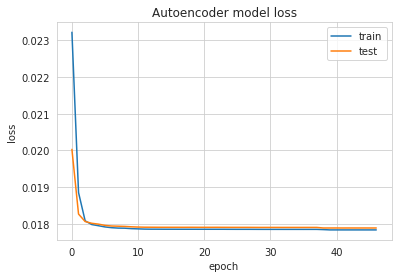

In [34]:
best_loss_value_ae_sigmoid_adam_logcosh = plot_hist_auto(hist_ae_sigmoid_adam_logcosh, './Figures/ae_sigmoid_adam_logcosh.png')

In [35]:
ae_siglin_adam_logcosh,enc_train_x_aslal,enc_test_x_aslal = ae(factor_enc_dim = 1.5,
                                                              enc_activation = 'sigmoid',
                                                              dec_activation = 'linear',
                                                              optimizer='Adam',
                                                              loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 197)               0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 131)               25938     
_________________________________________________________________
dense_2 (Dense)              (None, 197)               26004     
Total params: 51,942
Trainable params: 51,942
Non-trainable params: 0
_________________________________________________________________
None


In [36]:
#ae_siglin_adam_logcosh = load_model('ae_siglin_adam_logcosh_redds10bal.h5')

In [37]:
hist_ae_siglin_adam_logcosh = fit_ae(checkpoint_file = "ae_siglin_adam_logcosh_redds100bal.h5",
                                        autoencoder = ae_siglin_adam_logcosh, 
                                        epochs = 200, 
                                        batch_size = 197, 
                                        shuffle = False)

Mon Jun 10 16:32:57 2019
Train on 350620 samples, validate on 87656 samples
Epoch 1/200
350620/350620 [==============================] - 5s 13us/step - loss: 0.0041 - acc: 0.6016 - val_loss: 8.8688e-04 - val_acc: 0.7017
Epoch 2/200
350620/350620 [==============================] - 4s 13us/step - loss: 5.7996e-04 - acc: 0.7207 - val_loss: 4.2177e-04 - val_acc: 0.7470
Epoch 3/200
350620/350620 [==============================] - 4s 13us/step - loss: 3.5796e-04 - acc: 0.7320 - val_loss: 3.3154e-04 - val_acc: 0.7914
Epoch 4/200
350620/350620 [==============================] - 4s 13us/step - loss: 3.0681e-04 - acc: 0.7469 - val_loss: 3.0558e-04 - val_acc: 0.7690
Epoch 5/200
350620/350620 [==============================] - 4s 13us/step - loss: 2.8905e-04 - acc: 0.7560 - val_loss: 2.9310e-04 - val_acc: 0.7973
Epoch 6/200
350620/350620 [==============================] - 4s 13us/step - loss: 2.8015e-04 - acc: 0.7622 - val_loss: 2.8618e-04 - val_acc: 0.7952
Epoch 7/200
350620/350620 [=============

Best loss value: 0.00023520060815793224


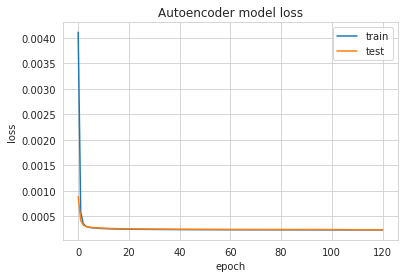

In [38]:
best_loss_value_ae_siglin_adam_logcosh = plot_hist_auto(hist_ae_siglin_adam_logcosh, './Figures/hist_ae_siglin_adam_logcosh.png')

In [39]:
ae_sigmoid_adam_mse,enc_train_x_asam,enc_test_x_asam = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'relu',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='mean_squared_error')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 197)               0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 131)               25938     
_________________________________________________________________
dense_3 (Dense)              (None, 197)               26004     
Total params: 51,942
Trainable params: 51,942
Non-trainable params: 0
_________________________________________________________________
None


In [40]:
#ae_sigmoid_adam_mse = load_model('ae_sigmoid_adam_mse_redds10bal.h5')

In [41]:
hist_ae_sigmoid_adam_mse = fit_ae(checkpoint_file = "ae_sigmoid_adam_mse_redds100bal.h5",
                                  autoencoder = ae_sigmoid_adam_mse, 
                                  epochs = 200, 
                                  batch_size = 197,
                                  shuffle = False)

Mon Jun 10 16:41:40 2019
Train on 350620 samples, validate on 87656 samples
Epoch 1/200
350620/350620 [==============================] - 4s 13us/step - loss: 0.0635 - acc: 0.2273 - val_loss: 0.0553 - val_acc: 0.3508
Epoch 2/200
350620/350620 [==============================] - 4s 13us/step - loss: 0.0533 - acc: 0.3480 - val_loss: 0.0526 - val_acc: 0.3678
Epoch 3/200
350620/350620 [==============================] - 4s 12us/step - loss: 0.0522 - acc: 0.3294 - val_loss: 0.0523 - val_acc: 0.2855
Epoch 4/200
350620/350620 [==============================] - 4s 12us/step - loss: 0.0520 - acc: 0.2919 - val_loss: 0.0522 - val_acc: 0.2766
Epoch 5/200
350620/350620 [==============================] - 4s 12us/step - loss: 0.0520 - acc: 0.2931 - val_loss: 0.0522 - val_acc: 0.2889
Epoch 6/200
350620/350620 [==============================] - 4s 13us/step - loss: 0.0519 - acc: 0.2846 - val_loss: 0.0521 - val_acc: 0.2849
Epoch 7/200
350620/350620 [==============================] - 4s 13us/step - loss: 0.

Best loss value: 0.05179758404595824


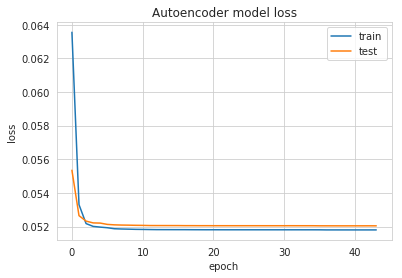

In [42]:
best_loss_value_ae_sigmoid_adam_mse  = plot_hist_auto(hist_ae_sigmoid_adam_mse, './Figures/hist_ae_sigmoid_adam_mse.png')

In [43]:
ae_sigsig_adam_logcosh,enc_train_x_assal,enc_test_x_assal = ae(factor_enc_dim = 1.5,
                                                          enc_activation = 'sigmoid',
                                                          dec_activation = 'sigmoid',
                                                          optimizer='Adam',
                                                          loss='logcosh')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 197)               0         
_________________________________________________________________
encoded_bottle_neck (Dense)  (None, 131)               25938     
_________________________________________________________________
dense_4 (Dense)              (None, 197)               26004     
Total params: 51,942
Trainable params: 51,942
Non-trainable params: 0
_________________________________________________________________
None


In [44]:
#ae_sigsig_adam_logcosh = load_model('ae_sigsig_adam_logcosh_redds10bal.h5')

In [45]:
hist_ae_sigsig_adam_logcosh = fit_ae(checkpoint_file = "ae_sigsig_adam_logcosh_redds100bal.h5",
                                  autoencoder = ae_sigsig_adam_logcosh, 
                                  epochs = 200, 
                                  batch_size = 197,
                                  shuffle = False)

Mon Jun 10 16:44:54 2019
Train on 350620 samples, validate on 87656 samples
Epoch 1/200
350620/350620 [==============================] - 5s 13us/step - loss: 0.0247 - acc: 0.1406 - val_loss: 0.0216 - val_acc: 0.2527
Epoch 2/200
350620/350620 [==============================] - 5s 13us/step - loss: 0.0211 - acc: 0.2992 - val_loss: 0.0208 - val_acc: 0.3462
Epoch 3/200
350620/350620 [==============================] - 5s 13us/step - loss: 0.0201 - acc: 0.3774 - val_loss: 0.0194 - val_acc: 0.3938
Epoch 4/200
350620/350620 [==============================] - 5s 13us/step - loss: 0.0188 - acc: 0.3939 - val_loss: 0.0185 - val_acc: 0.3835
Epoch 5/200
350620/350620 [==============================] - 5s 13us/step - loss: 0.0182 - acc: 0.3859 - val_loss: 0.0181 - val_acc: 0.3868
Epoch 6/200
350620/350620 [==============================] - 5s 13us/step - loss: 0.0180 - acc: 0.3844 - val_loss: 0.0180 - val_acc: 0.3889
Epoch 7/200
350620/350620 [==============================] - 5s 13us/step - loss: 0.

Best loss value: 0.017831129635252345


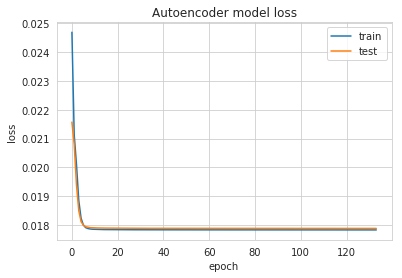

In [46]:
best_loss_value_ae_sigsig_adam_logcosh  = plot_hist_auto(hist_ae_sigsig_adam_logcosh, './Figures/hist_ae_sigsig_adam_logcosh.png')

In [47]:
loss_valueDict = {
    'loss_value_ae_sigmoid_adam_logcosh': best_loss_value_ae_sigmoid_adam_logcosh,
    'loss_value_ae_sigmoid_adam_mse': best_loss_value_ae_sigmoid_adam_mse,
    'loss_value_ae_siglin_adam_logcosh': best_loss_value_ae_siglin_adam_logcosh,
    'loss_value_ae_sigsig_adam_logcosh': best_loss_value_ae_sigsig_adam_logcosh
    }

In [48]:
loss_valueDict

{'loss_value_ae_sigmoid_adam_logcosh': 0.017835762382374845,
 'loss_value_ae_sigmoid_adam_mse': 0.05179758404595824,
 'loss_value_ae_siglin_adam_logcosh': 0.00023520060815793224,
 'loss_value_ae_sigsig_adam_logcosh': 0.017831129635252345}

In [49]:
print(enc_train_x_asal.shape)
print(enc_test_x_asal.shape)

print(enc_train_x_asam.shape)
print(enc_test_x_asam.shape)

print(enc_train_x_aslal.shape)
print(enc_test_x_aslal.shape)

print(enc_train_x_assal.shape)
print(enc_test_x_assal.shape)

(350620, 131)
(109570, 131)
(350620, 131)
(109570, 131)
(350620, 131)
(109570, 131)
(350620, 131)
(109570, 131)


#### ====================== Fail ANN ======================

In [50]:
ann36n_unisoftsigbinlosadam = ann_1h_36n(neurons=197,
                                      encoded_train_x=enc_train_x_asal,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 197)               26004     
_________________________________________________________________
dense_6 (Dense)              (None, 145)               28710     
_________________________________________________________________
batch_normalization_1 (Batch (None, 145)               580       
_________________________________________________________________
dropout_1 (Dropout)          (None, 145)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 146       
Total params: 55,440
Trainable params: 55,150
Non-trainable params: 290
_________________________________________________________________
None


In [51]:
hist_ann36n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann36n_unisoftsigbinlosadam_redds100bal.h5",
                                        ann = ann36n_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 197)

Mon Jun 10 16:54:26 2019
Train on 280496 samples, validate on 70124 samples
Epoch 1/200
280496/280496 [==============================] - 6s 21us/step - loss: 0.2076 - acc: 0.9055 - val_loss: 0.1233 - val_acc: 0.9440
Epoch 2/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0969 - acc: 0.9549 - val_loss: 0.0931 - val_acc: 0.9592
Epoch 3/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0799 - acc: 0.9627 - val_loss: 0.0722 - val_acc: 0.9667
Epoch 4/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0682 - acc: 0.9685 - val_loss: 0.0670 - val_acc: 0.9697
Epoch 5/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0620 - acc: 0.9719 - val_loss: 0.0606 - val_acc: 0.9742
Epoch 6/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0557 - acc: 0.9751 - val_loss: 0.0655 - val_acc: 0.9702
Epoch 7/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.

Best loss value: 0.018841576326731852


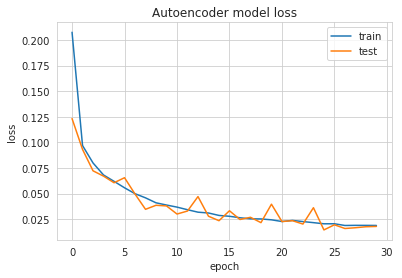

In [52]:
best_loss_value_ann36n_unisoftsigbinlosadam = plot_hist_auto(hist_ann36n_unisoftsigbinlosadam, './Figures/ann36_unisoftsigbinlosadam.png')

In [53]:
pred_ann36n_prob_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam = ann_predict(ann36n_unisoftsigbinlosadam,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.9913023637857078
              precision    recall  f1-score   support

           0     0.9899    0.9927    0.9913     54737
           1     0.9927    0.9899    0.9913     54833

   micro avg     0.9913    0.9913    0.9913    109570
   macro avg     0.9913    0.9913    0.9913    109570
weighted avg     0.9913    0.9913    0.9913    109570



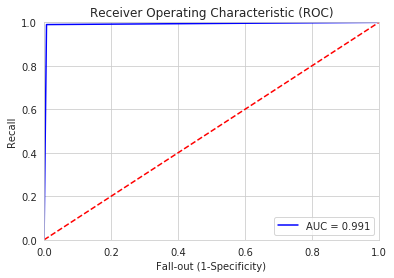

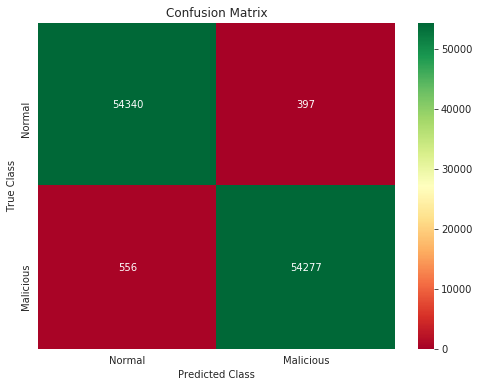

In [54]:
plot_roc_cm(pred_ann36n_01_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam, './Figures/ROC_ann36n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann36n_unisoftsigbinlosadam_redds10bal.png')

In [55]:
ann36n_unisoftsigbinlosadam2 = ann_1h_36n(neurons=197,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 197)               26004     
_________________________________________________________________
dense_9 (Dense)              (None, 145)               28710     
_________________________________________________________________
batch_normalization_2 (Batch (None, 145)               580       
_________________________________________________________________
dropout_2 (Dropout)          (None, 145)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 146       
Total params: 55,440
Trainable params: 55,150
Non-trainable params: 290
_________________________________________________________________
None


In [56]:
hist_ann36n_unisoftsigbinlosadam2 = ann_fit(checkpoint_file = "ann36n_unisoftsigbinlosadam2_redds100bal.h5",
                                        ann = ann36n_unisoftsigbinlosadam2,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 197)

Mon Jun 10 16:57:14 2019
Train on 280496 samples, validate on 70124 samples
Epoch 1/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.1993 - acc: 0.9097 - val_loss: 0.1098 - val_acc: 0.9505
Epoch 2/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0965 - acc: 0.9533 - val_loss: 0.0843 - val_acc: 0.9619
Epoch 3/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0820 - acc: 0.9610 - val_loss: 0.0714 - val_acc: 0.9667
Epoch 4/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0725 - acc: 0.9656 - val_loss: 0.0655 - val_acc: 0.9687
Epoch 5/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0635 - acc: 0.9700 - val_loss: 0.0573 - val_acc: 0.9744
Epoch 6/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0571 - acc: 0.9737 - val_loss: 0.0592 - val_acc: 0.9739
Epoch 7/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.

Best loss value: 0.017978080803306703


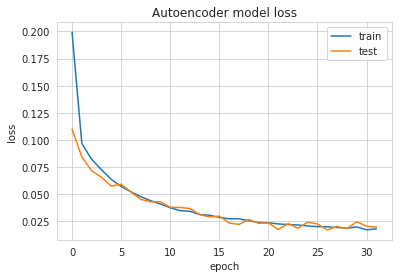

In [57]:
best_loss_value_ann36n_unisoftsigbinlosadam2 = plot_hist_auto(hist_ann36n_unisoftsigbinlosadam2, './Figures/ann36_unisoftsigbinlosadam2.png')

In [58]:
pred_ann36n_prob_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam2 = ann_predict(ann36n_unisoftsigbinlosadam2,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9909829332846583
              precision    recall  f1-score   support

           0     0.9941    0.9878    0.9909     54737
           1     0.9879    0.9942    0.9910     54833

   micro avg     0.9910    0.9910    0.9910    109570
   macro avg     0.9910    0.9910    0.9910    109570
weighted avg     0.9910    0.9910    0.9910    109570



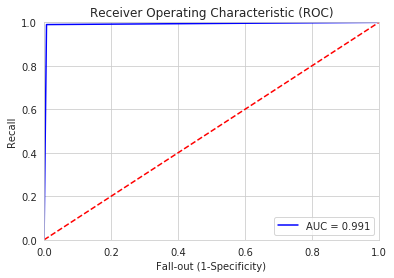

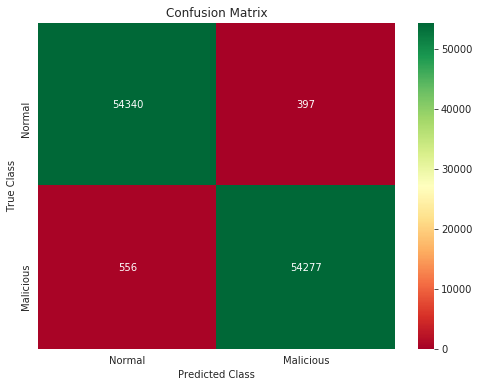

In [59]:
plot_roc_cm(pred_ann36n_01_unisoftsigbinlosadam, pred_ann36n_01_unisoftsigbinlosadam, './Figures/ROC_ann36n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann36n_unisoftsigbinlosadam_redds10bal.png')

In [60]:
ann24n_unisoftsigbinlosadam = ann_1h_24n(neurons=197,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 197)               26004     
_________________________________________________________________
dense_12 (Dense)             (None, 95)                18810     
_________________________________________________________________
batch_normalization_3 (Batch (None, 95)                380       
_________________________________________________________________
dropout_3 (Dropout)          (None, 95)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 1)                 96        
Total params: 45,290
Trainable params: 45,100
Non-trainable params: 190
_________________________________________________________________
None


In [61]:
hist_ann24n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann24n_unisoftsigbinlosadam_redds100bal.h5",
                                        ann = ann24n_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 197)

Mon Jun 10 17:00:14 2019
Train on 280496 samples, validate on 70124 samples
Epoch 1/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.2130 - acc: 0.9033 - val_loss: 0.1082 - val_acc: 0.9507
Epoch 2/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.1016 - acc: 0.9517 - val_loss: 0.0873 - val_acc: 0.9595
Epoch 3/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0860 - acc: 0.9588 - val_loss: 0.0735 - val_acc: 0.9656
Epoch 4/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0754 - acc: 0.9639 - val_loss: 0.0731 - val_acc: 0.9655
Epoch 5/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.0682 - acc: 0.9675 - val_loss: 0.0707 - val_acc: 0.9655
Epoch 6/200
280496/280496 [==============================] - 6s 21us/step - loss: 0.0628 - acc: 0.9707 - val_loss: 0.0645 - val_acc: 0.9707
Epoch 7/200
280496/280496 [==============================] - 6s 20us/step - loss: 0.

Best loss value: 0.018001740853350486


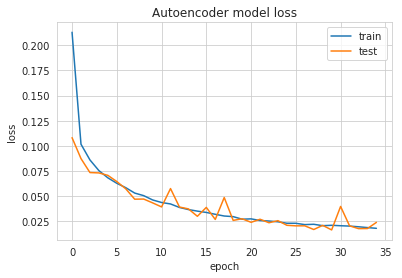

In [62]:
best_loss_value_ann24n_unisoftsigbinlosadam = plot_hist_auto(hist_ann24n_unisoftsigbinlosadam, './Figures/ann24_unisoftsigbinlosadam.png')

In [63]:
pred_ann24n_prob_unisoftsigbinlosadam, pred_ann24n_01_unisoftsigbinlosadam = ann_predict(ann24n_unisoftsigbinlosadam,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9891849958930364
              precision    recall  f1-score   support

           0     0.9872    0.9912    0.9892     54737
           1     0.9911    0.9872    0.9892     54833

   micro avg     0.9892    0.9892    0.9892    109570
   macro avg     0.9892    0.9892    0.9892    109570
weighted avg     0.9892    0.9892    0.9892    109570



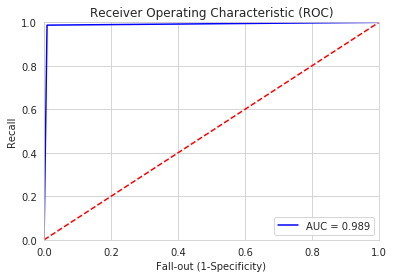

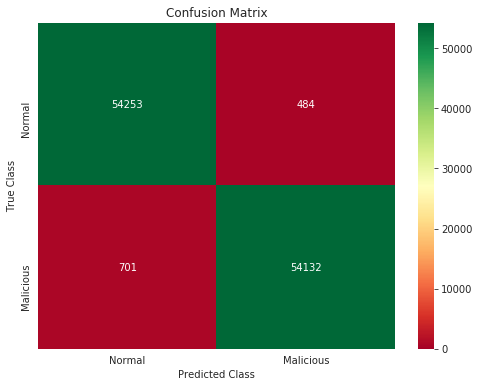

In [64]:
plot_roc_cm(pred_ann24n_01_unisoftsigbinlosadam, pred_ann24n_01_unisoftsigbinlosadam, './Figures/ROC_ann24n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann24n_unisoftsigbinlosadam_redds10bal.png')

In [65]:
ann_2h_unisoftsigbinlosadam = ann_2h(neurons=197,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 197)               26004     
_________________________________________________________________
dense_15 (Dense)             (None, 145)               28710     
_________________________________________________________________
dense_16 (Dense)             (None, 95)                13870     
_________________________________________________________________
batch_normalization_4 (Batch (None, 95)                380       
_________________________________________________________________
dropout_4 (Dropout)          (None, 95)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 1)                 96        
Total params: 69,060
Trainable params: 68,870
Non-trainable params: 190
_________________________________________________________________
None

In [66]:
hist_ann_2h_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam_redds100bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 197)

Mon Jun 10 17:03:31 2019
Train on 280496 samples, validate on 70124 samples
Epoch 1/200
280496/280496 [==============================] - 7s 24us/step - loss: 0.1932 - acc: 0.9064 - val_loss: 0.1015 - val_acc: 0.9485
Epoch 2/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0992 - acc: 0.9501 - val_loss: 0.0824 - val_acc: 0.9593
Epoch 3/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0807 - acc: 0.9599 - val_loss: 0.0769 - val_acc: 0.9630
Epoch 4/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0677 - acc: 0.9676 - val_loss: 0.0677 - val_acc: 0.9690
Epoch 5/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0562 - acc: 0.9738 - val_loss: 0.0471 - val_acc: 0.9798
Epoch 6/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0482 - acc: 0.9776 - val_loss: 0.0556 - val_acc: 0.9752
Epoch 7/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.

In [67]:
hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

[array([[-0.33809593,  0.18339203, -0.05820699, ...,  0.00622355,
          0.1292724 ,  0.19632725],
        [ 0.10242213,  0.07285095, -0.09593306, ..., -0.11746947,
          0.05461504,  0.14450881],
        [ 0.17260912, -0.27859548, -0.3731489 , ..., -0.15466368,
         -0.02157056, -0.0965628 ],
        ...,
        [-0.29469988, -0.15000366, -0.01136683, ...,  0.03979791,
         -0.0009403 ,  0.12171873],
        [ 0.28233454, -0.02594135, -0.29140225, ..., -0.14933765,
          0.24773662,  0.12092172],
        [-0.24573813, -0.28913882,  0.05755954, ..., -0.03857537,
          0.32675502,  0.35283533]], dtype=float32),
 array([-0.05062636, -0.03712564,  0.01963398, -0.06001037, -0.00206709,
         0.02931684, -0.00323904, -0.01422545, -0.02991621,  0.00789905,
        -0.10763286, -0.04559083,  0.05011971,  0.02898466, -0.02241161,
         0.02296308, -0.03120034, -0.01891614,  0.08429284,  0.08527653,
        -0.03942732,  0.01852222,  0.01065726,  0.00218295,  0.058

Best loss value: 0.01636940101247013


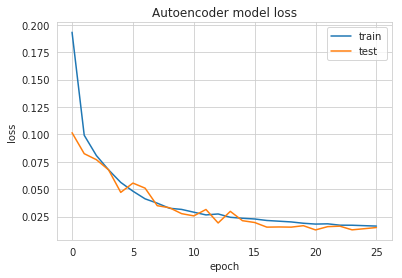

In [68]:
best_loss_value_ann_2h_unisoftsigbinlosadam = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam, './Figures/ann_2h_unisoftsigbinlosadam.png')

In [69]:
pred_ann_2h_prob_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam = ann_predict(ann_2h_unisoftsigbinlosadam,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9934014785068905
              precision    recall  f1-score   support

           0     0.9959    0.9909    0.9934     54737
           1     0.9909    0.9959    0.9934     54833

   micro avg     0.9934    0.9934    0.9934    109570
   macro avg     0.9934    0.9934    0.9934    109570
weighted avg     0.9934    0.9934    0.9934    109570



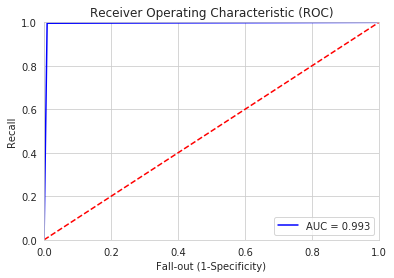

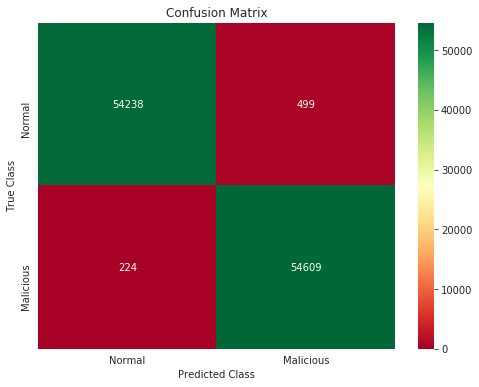

In [70]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam, pred_ann_2h_01_unisoftsigbinlosadam, './Figures/ROC_ann_2h_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam_redds10bal.png')

In [71]:
ann_2h_unisoftsigbinlosadam2 = ann_2h_(neurons=197,
                                      encoded_train_x=enc_train_x_asal,
#                                       init_mode='glorot_uniform',
                                       init_mode='VarianceScaling',
#                                       activation_input='softsign',
                                      activation_input='relu',
#                                       weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      lr=0.05)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 197)               26004     
_________________________________________________________________
dense_19 (Dense)             (None, 145)               28710     
_________________________________________________________________
dense_20 (Dense)             (None, 95)                13870     
_________________________________________________________________
batch_normalization_5 (Batch (None, 95)                380       
_________________________________________________________________
dropout_5 (Dropout)          (None, 95)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 96        
Total params: 69,060
Trainable params: 68,870
Non-trainable params: 190
_________________________________________________________________
None

In [72]:
hist_ann_2h_unisoftsigbinlosadam2 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam2_redds100bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam2,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 197)

Mon Jun 10 17:06:13 2019
Train on 280496 samples, validate on 70124 samples
Epoch 1/200
280496/280496 [==============================] - 7s 24us/step - loss: 0.2470 - acc: 0.8783 - val_loss: 0.1505 - val_acc: 0.9277
Epoch 2/200
280496/280496 [==============================] - 6s 21us/step - loss: 0.1148 - acc: 0.9444 - val_loss: 0.0972 - val_acc: 0.9517
Epoch 3/200
280496/280496 [==============================] - 6s 21us/step - loss: 0.0985 - acc: 0.9512 - val_loss: 0.0940 - val_acc: 0.9543
Epoch 4/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0873 - acc: 0.9569 - val_loss: 0.0763 - val_acc: 0.9606
Epoch 5/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0789 - acc: 0.9609 - val_loss: 0.0963 - val_acc: 0.9531
Epoch 6/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0749 - acc: 0.9637 - val_loss: 0.0794 - val_acc: 0.9612
Epoch 7/200
280496/280496 [==============================] - 6s 21us/step - loss: 0.

Best loss value: 0.028761532210218998


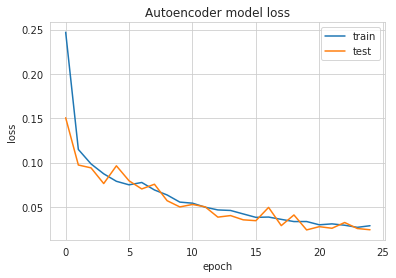

In [73]:
best_loss_value_ann_2h_unisoftsigbinlosadam2 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam2, './Figures/ann_2h_unisoftsigbinlosadam2.png')

In [74]:
pred_ann_2h_prob_unisoftsigbinlosadam2, pred_ann_2h_01_unisoftsigbinlosadam2 = ann_predict(ann_2h_unisoftsigbinlosadam2,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.990006388610021
              precision    recall  f1-score   support

           0     0.9917    0.9882    0.9900     54737
           1     0.9883    0.9918    0.9900     54833

   micro avg     0.9900    0.9900    0.9900    109570
   macro avg     0.9900    0.9900    0.9900    109570
weighted avg     0.9900    0.9900    0.9900    109570



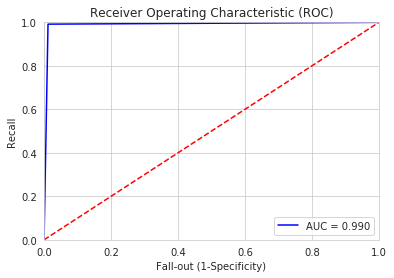

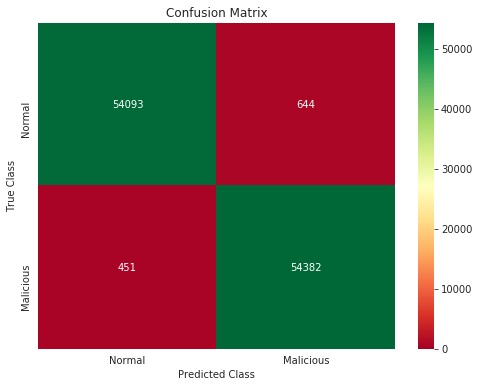

In [75]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam2, pred_ann_2h_01_unisoftsigbinlosadam2, './Figures/ROC_ann_2h_unisoftsigbinlosadam2_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam2_redds10bal.png')

In [76]:
ann_2h_unisoftsigbinlosadam3 = ann_2h(neurons=197,
                                      encoded_train_x=enc_train_x_asam,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 197)               26004     
_________________________________________________________________
dense_23 (Dense)             (None, 145)               28710     
_________________________________________________________________
dense_24 (Dense)             (None, 95)                13870     
_________________________________________________________________
batch_normalization_6 (Batch (None, 95)                380       
_________________________________________________________________
dropout_6 (Dropout)          (None, 95)                0         
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 96        
Total params: 69,060
Trainable params: 68,870
Non-trainable params: 190
_________________________________________________________________
None

In [77]:
hist_ann_2h_unisoftsigbinlosadam3 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam3_redds100bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam3,
                                        enc_train_x = enc_train_x_asam,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 197)

Mon Jun 10 17:08:46 2019
Train on 280496 samples, validate on 70124 samples
Epoch 1/200
280496/280496 [==============================] - 7s 25us/step - loss: 0.1703 - acc: 0.9169 - val_loss: 0.0935 - val_acc: 0.9506
Epoch 2/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0927 - acc: 0.9533 - val_loss: 0.0900 - val_acc: 0.9569
Epoch 3/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0774 - acc: 0.9612 - val_loss: 0.0675 - val_acc: 0.9662
Epoch 4/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0677 - acc: 0.9675 - val_loss: 0.0578 - val_acc: 0.9706
Epoch 5/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0569 - acc: 0.9730 - val_loss: 0.0602 - val_acc: 0.9728
Epoch 6/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0503 - acc: 0.9762 - val_loss: 0.0449 - val_acc: 0.9777
Epoch 7/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.

In [78]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.013529218654662832


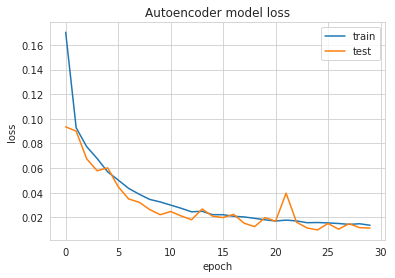

In [79]:
best_loss_value_ann_2h_unisoftsigbinlosadam3 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam3, './Figures/ann_2h_unisoftsigbinlosadam3.png')

In [80]:
pred_ann_2h_prob_unisoftsigbinlosadam3, pred_ann_2h_01_unisoftsigbinlosadam3 = ann_predict(ann_2h_unisoftsigbinlosadam3,enc_test_x_asam)

Overall accuracy of Neural Network model: 0.9946792005110888
              precision    recall  f1-score   support

           0     0.9943    0.9951    0.9947     54737
           1     0.9951    0.9943    0.9947     54833

   micro avg     0.9947    0.9947    0.9947    109570
   macro avg     0.9947    0.9947    0.9947    109570
weighted avg     0.9947    0.9947    0.9947    109570



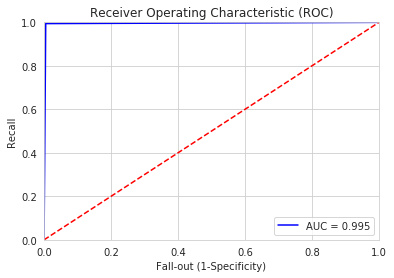

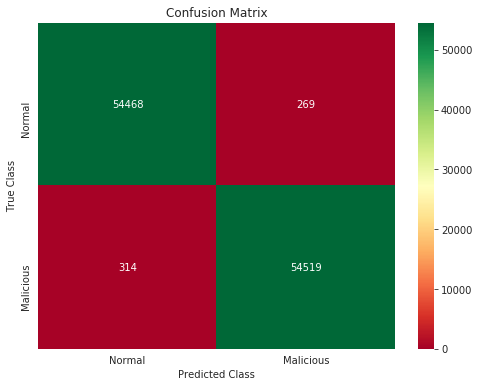

In [81]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam3, pred_ann_2h_01_unisoftsigbinlosadam3, './Figures/ROC_ann_2h_unisoftsigbinlosadam3_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam3_redds10bal.png')

#### >>>>>>>>>>>>>>>>>>>

In [82]:
ann_2h_unisoftsigbinlosadam4 = ann_2h(neurons=197,
                                      encoded_train_x=enc_train_x_asal,
                                      init_mode='uniform',
                                      activation_input='relu',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 197)               26004     
_________________________________________________________________
dense_27 (Dense)             (None, 145)               28710     
_________________________________________________________________
dense_28 (Dense)             (None, 95)                13870     
_________________________________________________________________
batch_normalization_7 (Batch (None, 95)                380       
_________________________________________________________________
dropout_7 (Dropout)          (None, 95)                0         
_________________________________________________________________
dense_29 (Dense)             (None, 1)                 96        
Total params: 69,060
Trainable params: 68,870
Non-trainable params: 190
_________________________________________________________________
None

In [83]:
hist_ann_2h_unisoftsigbinlosadam4 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam4_redds100bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam4,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 197)

Mon Jun 10 17:11:55 2019
Train on 280496 samples, validate on 70124 samples
Epoch 1/200
280496/280496 [==============================] - 7s 26us/step - loss: 0.1641 - acc: 0.9193 - val_loss: 0.1053 - val_acc: 0.9501
Epoch 2/200
280496/280496 [==============================] - 6s 23us/step - loss: 0.0928 - acc: 0.9528 - val_loss: 0.0921 - val_acc: 0.9564
Epoch 3/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0735 - acc: 0.9638 - val_loss: 0.0706 - val_acc: 0.9666
Epoch 4/200
280496/280496 [==============================] - 6s 23us/step - loss: 0.0589 - acc: 0.9722 - val_loss: 0.0553 - val_acc: 0.9719
Epoch 5/200
280496/280496 [==============================] - 6s 22us/step - loss: 0.0491 - acc: 0.9773 - val_loss: 0.0416 - val_acc: 0.9814
Epoch 6/200
280496/280496 [==============================] - 6s 23us/step - loss: 0.0434 - acc: 0.9805 - val_loss: 0.0391 - val_acc: 0.9810
Epoch 7/200
280496/280496 [==============================] - 6s 23us/step - loss: 0.

In [84]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.014463238181232305


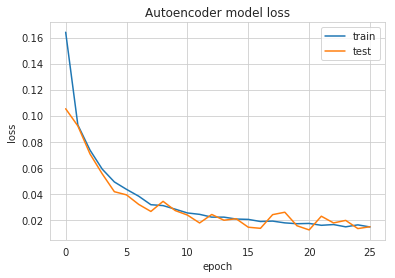

In [85]:
best_loss_value_ann_2h_unisoftsigbinlosadam4 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam4, './Figures/ann_2h_unisoftsigbinlosadam4.png')

In [86]:
pred_ann_2h_prob_unisoftsigbinlosadam4, pred_ann_2h_01_unisoftsigbinlosadam4 = ann_predict(ann_2h_unisoftsigbinlosadam4,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.993547503878799
              precision    recall  f1-score   support

           0     0.9989    0.9882    0.9935     54737
           1     0.9883    0.9989    0.9936     54833

   micro avg     0.9935    0.9935    0.9935    109570
   macro avg     0.9936    0.9935    0.9935    109570
weighted avg     0.9936    0.9935    0.9935    109570



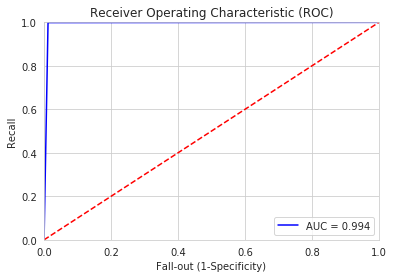

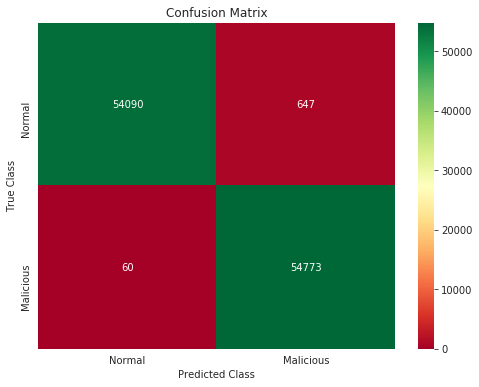

In [87]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam4, pred_ann_2h_01_unisoftsigbinlosadam4, './Figures/ROC_ann_2h_unisoftsigbinlosadam4_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam4_redds10bal.png')

ann_2h__(neurons,encoded_train_x,activation_input,
               dropout_rate,activation_output,
               loss,optimizer)

In [88]:
from keras.utils import to_categorical
train_y_ = to_categorical(train_y)

In [89]:
ann_2h_unisoftsigbinlosadam8 = ann_2h__(neurons=197,
                                      encoded_train_x=enc_train_x_asal,
                                      activation_input='tanh',
#                                       dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='mean_squared_error',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_30 (Dense)             (None, 197)               26004     
_________________________________________________________________
dense_31 (Dense)             (None, 145)               28710     
_________________________________________________________________
dense_32 (Dense)             (None, 95)                13870     
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 96        
Total params: 68,680
Trainable params: 68,680
Non-trainable params: 0
_________________________________________________________________
None


In [90]:
hist_ann_2h_unisoftsigbinlosadam8 = ann_fit(checkpoint_file = "ann_2h_unisoftsigbinlosadam8_redds100bal.h5",
                                        ann = ann_2h_unisoftsigbinlosadam8,
                                        enc_train_x = enc_train_x_asal,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 197)

Mon Jun 10 17:14:40 2019
Train on 280496 samples, validate on 70124 samples
Epoch 1/200
280496/280496 [==============================] - 5s 18us/step - loss: 0.0675 - acc: 0.9048 - val_loss: 0.0346 - val_acc: 0.9482
Epoch 2/200
280496/280496 [==============================] - 4s 15us/step - loss: 0.0286 - acc: 0.9596 - val_loss: 0.0242 - val_acc: 0.9658
Epoch 3/200
280496/280496 [==============================] - 4s 16us/step - loss: 0.0235 - acc: 0.9672 - val_loss: 0.0177 - val_acc: 0.9755
Epoch 4/200
280496/280496 [==============================] - 4s 16us/step - loss: 0.0198 - acc: 0.9726 - val_loss: 0.0266 - val_acc: 0.9631
Epoch 5/200
280496/280496 [==============================] - 4s 15us/step - loss: 0.0163 - acc: 0.9777 - val_loss: 0.0200 - val_acc: 0.9727
Epoch 6/200
280496/280496 [==============================] - 4s 15us/step - loss: 0.0152 - acc: 0.9793 - val_loss: 0.0156 - val_acc: 0.9785
Epoch 7/200
280496/280496 [==============================] - 4s 15us/step - loss: 0.

In [91]:
# hist_ann_2h_unisoftsigbinlosadam.model.get_weights()

Best loss value: 0.007702831378110759


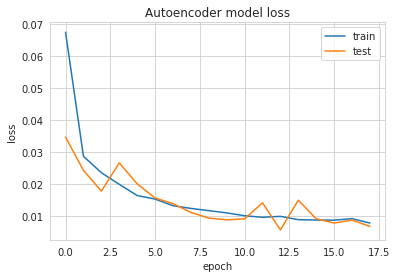

In [92]:
best_loss_value_ann_2h_unisoftsigbinlosadam8 = plot_hist_auto(hist_ann_2h_unisoftsigbinlosadam8, './Figures/ann_2h_unisoftsigbinlosadam8.png')

In [93]:
pred_ann_2h_prob_unisoftsigbinlosadam8, pred_ann_2h_01_unisoftsigbinlosadam8 = ann_predict(ann_2h_unisoftsigbinlosadam8,enc_test_x_asal)

Overall accuracy of Neural Network model: 0.991311490371452
              precision    recall  f1-score   support

           0     0.9938    0.9888    0.9913     54737
           1     0.9889    0.9938    0.9913     54833

   micro avg     0.9913    0.9913    0.9913    109570
   macro avg     0.9913    0.9913    0.9913    109570
weighted avg     0.9913    0.9913    0.9913    109570



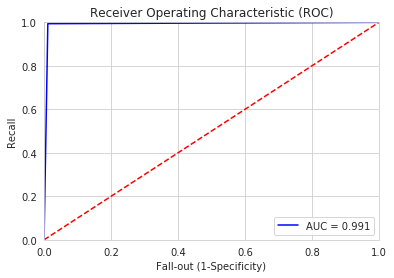

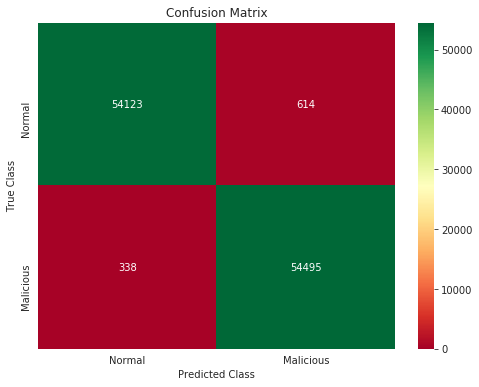

In [94]:
plot_roc_cm(pred_ann_2h_01_unisoftsigbinlosadam8, pred_ann_2h_01_unisoftsigbinlosadam8, './Figures/ROC_ann_2h_unisoftsigbinlosadam8_redds10bal.png', './Figures/CM_ann_2h_unisoftsigbinlosadam8_redds10bal.png')

In [95]:
ann_24n_unisoftsigbinlosadam = ann_1h_24n(neurons=197,
                                      encoded_train_x=train_x,
                                      init_mode='uniform',
                                      activation_input='softsign',
                                      weight_constraint=5,
                                      dropout_rate=0.0,
                                      activation_output='sigmoid',
                                      loss='binary_crossentropy',
                                      optimizer='Adam')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_34 (Dense)             (None, 197)               39006     
_________________________________________________________________
dense_35 (Dense)             (None, 95)                18810     
_________________________________________________________________
batch_normalization_8 (Batch (None, 95)                380       
_________________________________________________________________
dropout_8 (Dropout)          (None, 95)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 96        
Total params: 58,292
Trainable params: 58,102
Non-trainable params: 190
_________________________________________________________________
None


In [96]:
hist_ann_24n_unisoftsigbinlosadam = ann_fit(checkpoint_file = "ann_24n_unisoftsigbinlosadam_redds100bal.h5",
                                        ann = ann_24n_unisoftsigbinlosadam,
                                        enc_train_x = train_x,
                                        train_y = train_y,
                                        epochs = 200,
                                        shuffle = True,
                                        batch_size = 197)

Mon Jun 10 17:16:01 2019
Train on 280496 samples, validate on 70124 samples
Epoch 1/200
280496/280496 [==============================] - 9s 32us/step - loss: 0.1205 - acc: 0.9458 - val_loss: 0.0594 - val_acc: 0.9744
Epoch 2/200
280496/280496 [==============================] - 8s 28us/step - loss: 0.0507 - acc: 0.9780 - val_loss: 0.0348 - val_acc: 0.9853
Epoch 3/200
280496/280496 [==============================] - 8s 28us/step - loss: 0.0351 - acc: 0.9855 - val_loss: 0.0263 - val_acc: 0.9911
Epoch 4/200
280496/280496 [==============================] - 8s 28us/step - loss: 0.0286 - acc: 0.9884 - val_loss: 0.0283 - val_acc: 0.9889
Epoch 5/200
280496/280496 [==============================] - 8s 29us/step - loss: 0.0263 - acc: 0.9896 - val_loss: 0.0189 - val_acc: 0.9920
Epoch 6/200
280496/280496 [==============================] - 8s 29us/step - loss: 0.0215 - acc: 0.9915 - val_loss: 0.0183 - val_acc: 0.9931
Epoch 7/200
280496/280496 [==============================] - 8s 28us/step - loss: 0.

Best loss value: 0.015080331424955093


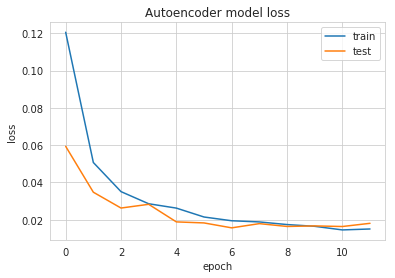

In [97]:
best_loss_value_ann_24n_unisoftsigbinlosadam = plot_hist_auto(hist_ann_24n_unisoftsigbinlosadam, './Figures/ann_24_unisoftsigbinlosadam.png')

In [98]:
pred_ann_24n_prob_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam = ann_predict(ann_24n_unisoftsigbinlosadam,test_x)

Overall accuracy of Neural Network model: 0.9934744911928448
              precision    recall  f1-score   support

           0     0.9988    0.9881    0.9934     54737
           1     0.9883    0.9988    0.9935     54833

   micro avg     0.9935    0.9935    0.9935    109570
   macro avg     0.9935    0.9935    0.9935    109570
weighted avg     0.9935    0.9935    0.9935    109570



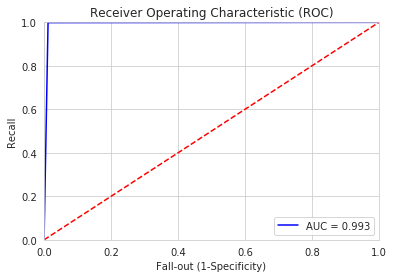

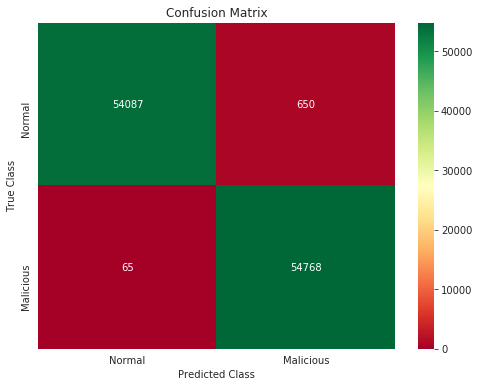

In [99]:
plot_roc_cm(pred_ann_24n_01_unisoftsigbinlosadam, pred_ann_24n_01_unisoftsigbinlosadam, './Figures/ROC_ann_24n_unisoftsigbinlosadam_redds10bal.png', './Figures/CM_ann_24n_unisoftsigbinlosadam_redds10bal.png')

In [100]:
from sklearn.ensemble import RandomForestClassifier

In [101]:
clf = RandomForestClassifier(n_estimators=300, 
                             criterion='gini', 
                             max_depth=16, 
#                              min_samples_split=2, 
                             #min_samples_leaf=1, 
                             max_features=0.3, 
                             #bootstrap=True,
                             oob_score=True,
                             random_state=23)  

In [102]:
start_time = time.time()
print(time.ctime(start_time))

clf.fit(enc_train_x_aslal, train_y)

pred_y_RF = cross_val_predict(estimator=clf,
                              X=np.array(enc_test_x_aslal),
                              y=test_y,
                              cv=KFold(n_splits=10, random_state=23),
                              n_jobs=2)

elapsed_time = (time.time() - start_time)
print("--- %s seconds ---" %elapsed_time)

print(sm.classification_report(test_y, pred_y_RF,digits=4))

Mon Jun 10 17:17:42 2019
--- 9501.099874019623 seconds ---
              precision    recall  f1-score   support

           0     0.9790    0.9986    0.9887     54737
           1     0.9986    0.9786    0.9885     54833

   micro avg     0.9886    0.9886    0.9886    109570
   macro avg     0.9888    0.9886    0.9886    109570
weighted avg     0.9888    0.9886    0.9886    109570



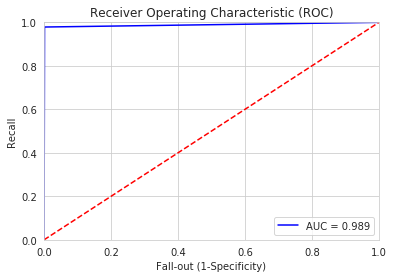

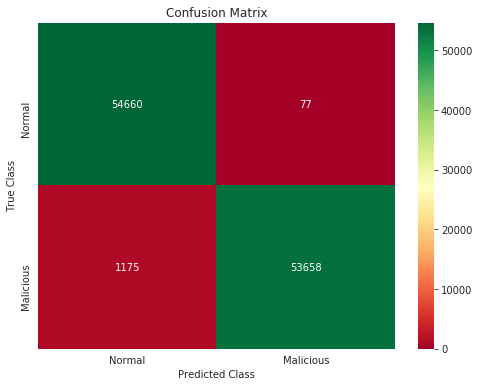

In [103]:
plot_roc_cm(pred_y_RF, pred_y_RF, './Figures/ROC_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png', './Figures/CM_rf_E100MaxfautoMaxdnoneBootT_redds10bal.png')